## 텐서플로 회귀 모델 만들기
* [자동차 연비 예측하기: 회귀  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv("http://bit.ly/data-diabetes-csv")
df.shape

(768, 9)

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
# Insulin 값이 0보다 큰 값만 사용합니다.
df = df[df["Insulin"] > 0].copy()
df.shape

(394, 9)

In [23]:
# label_name 을 Insulin 으로 합니다.
label_name = "Insulin"
label_name

'Insulin'

In [24]:
# train, test 데이터셋을 pandas 의 sample을 사용해서 8:2로 나눕니다.

train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
train.shape, test.shape

((315, 9), (79, 9))

In [25]:
X_train = train.drop(columns=label_name)
X_test = test.drop(columns=label_name)
y_train = train[label_name]
y_test = test[label_name]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((315, 8), (79, 8), (315,), (79,))

<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

* [자동차 연비 예측하기: 회귀  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression)

* 층 설정
    * 신경망의 기본 구성 요소는 층(layer)입니다. 
    * 층은 주입된 데이터에서 표현을 추출합니다. 
    * 대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. 
    * tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

* Dense Layer: 
    * 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 
    * 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 
    * 마지막 층은 출력층 입니다.
        * 소프트맥스 일 때 : 2개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 2개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 
        * 각 노드는 현재 이미지가 2개 클래스 중 하나에 속할 확률을 출력합니다.
        * 시그모이드 일 때 : 둘 중 하나를 예측할 때 1개의 출력값을 출력합니다. 확률을 받아 임계값 기준으로 True, False로 나눕니다.
    
    * 출력층 :
        * 분류 예측 값이 n개 일 때 :  tf.keras.layers.Dense(n, activation='softmax')
        * 분류 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid')
        * 회귀 예측 일 때 : tf.keras.layers.Dense(1, activation='linear')
    
    
* 드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

* tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다. (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [26]:
# tensorflow 를 tf로 불러오기
import tensorflow as tf

In [27]:
# input_shape 값을 구합니다. feature의 수로 만듭니다.
input_shape = X_train.shape[1]
input_shape

8

In [176]:
# 입력 레이어를 Input 레이어로 사용할 수도 있습니다.  tf.keras.layers.Input(shape=(input_shape))
# 분류와 똑같지만 회귀는 출력을 하나로 합니다.  tf.keras.layers.Dense(1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='selu', input_shape=[input_shape]),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),         
])
model

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

* 옵티마이저(Optimizer) - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표(Metrics) - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


* 손실 함수(Loss function) - 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다. 최적의 가중치를 찾도록 해야함
    * 회귀  : MSE, MAE
    * 분류 : 
        * binary_crossentropy
        * categorical_crossentropy(one-hot형태의 클래스 예: [0, 1, 0, 0])
        * sparse_categorical_crossentropy(정답값이 0, 1, 2, 3, 4 와 같은 형태일 때)


In [177]:
print(dir(tf.keras.optimizers))

['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'deserialize', 'experimental', 'get', 'legacy', 'schedules', 'serialize']


In [178]:
# 모델을 컴파일 합니다.
optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=["mse"], 
              optimizer=optimizer,
              metrics=["mae", "mse"])

In [179]:
# 모델을 요약합니다.
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 256)               2304      
                                                                 
 dense_63 (Dense)            (None, 128)               32896     
                                                                 
 dense_64 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_65 (Dense)            (None, 128)               16512     
                                                                 
 dense_66 (Dense)            (None, 128)               16512     
                                                                 
 dropout_22 (Dropout)        (None, 128)             

## 학습
* 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

In [180]:
# 모델을 학습합니다.
# 학습결과를 history 변수에 할당합니다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(X_train, y_train, 
                    validation_split=0.2, verbose=0, epochs=1000, callbacks=[early_stop])

In [181]:
# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
418,4649.799805,49.481632,4649.799805,9597.490234,61.450218,9597.490234
419,4847.011719,50.388988,4847.011719,9735.293945,60.549656,9735.293945
420,4220.946777,47.242317,4220.946777,9504.736328,60.522114,9504.736328
421,4213.273926,47.478523,4213.273926,9701.699219,60.507568,9701.699219
422,4073.428955,45.367134,4073.428955,9562.267578,61.795975,9562.267578


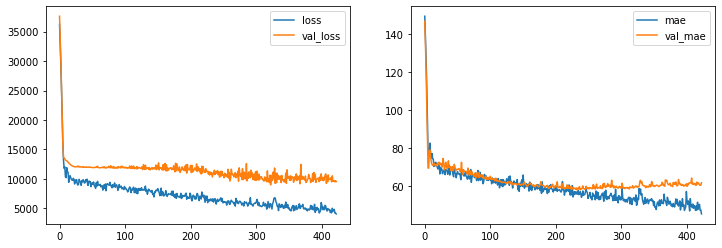

In [182]:
# 학습결과를 시각화 합니다.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
df_hist[["loss", "val_loss"]].plot(ax=axes[0])
df_hist[["mae", "val_mae"]].plot(ax=axes[1])

## 예측

In [183]:
y_pred = model.predict(X_test)
y_pred.shape

3/3 [==============================] - 0s 4ms/step


(79, 1)

In [184]:
y_test.shape

(79,)

In [185]:
y_pred.shape

(79, 1)

In [186]:
# 예측값을 flatten을 사용해 1차원으로 변환합니다. 
y_predict = y_pred.flatten()
y_predict[:5]

array([ 99.5067  , 152.85768 ,  61.26531 , 123.313065,  64.04035 ],
      dtype=float32)

## 평가

In [187]:
# evaluate를 통해 평가하기
loss, mae, mse  = model.evaluate(X_test, y_test)
print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

3/3 [==============================] - 0s 4ms/step - loss: 13190.8086 - mae: 69.7993 - mse: 13190.8086
테스트 세트의 평균 절대 오차: 69.80


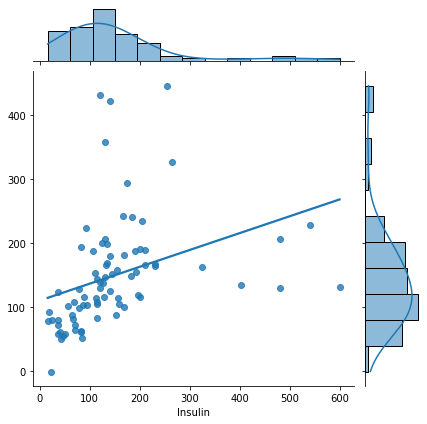

In [188]:
# jointplot 으로 실제값과 예측값을 시각화 합니다.
sns.jointplot(x=y_test, y=y_predict, kind="reg", ci=None)

### MAE(Mean Absolute Error)
* [Mean absolute error - Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)

In [189]:
# y_predict
# 58.523619283603715

In [190]:
# 예측값과 실제값의 차이에 대한 절대값의 평균
error = y_test - y_predict
mae = abs(error).mean()
mae

69.79926277263255

### MAPE(Mean Absolute Percentage Error)

In [70]:
# (실제값 - 예측값 / 실제값)의 절대값에 대한 평균
mape = abs(error / y_test).mean()
mape

0.6256985866088941

### MSE(Mean Squared Error)

In [53]:
# 실제값 - 예측값의 차이의 제곱의 평균
# MAE와 비슷해 보이나 제곱을 통해 음수를 양수로 변환함
# 분산과 유사한 공식
mse = (error ** 2).mean()
mse

10412.961254665282

### RMSE(Root Mean Squared Error)

In [54]:
# MSE 값에 Root를 취함, 표준편차와 유사한 공식
rmse = np.sqrt(mse)
rmse

102.04391826397732